# Notebook de Modelagem e Treinamento


- Objetivo: Responsável por carregar os dados e realizar o treinamento dos Regressores. Adicionalmente, avalia a qualidade dos pontos chaves gerados dos métodos de Detecção de Pontos Chaves.

Vamos clonar o repositório com o código fonte do projeto

---



In [1]:
!git clone  https://github.com/marceloluisr/Desafio_INOVAI_2025.git

Cloning into 'deteccao_pontos_chaves'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 124 (delta 0), reused 2 (delta 0), pack-reused 121 (from 1)
Receiving objects: 100% (124/124), 33.00 MiB | 24.99 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [12]:
USE_COLAB = True  # ou Falso dependendo do ambiente.

Vamos montar o drive no ambiente de execução para acessar o dados. IMPORTANTE:
a montagem do drive requer permitir acesso do Google Colab para o drive e os dados devem estar disponíveis.


In [13]:
if USE_COLAB:
  # montando google drive no ambiente para acessar dataset
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys

codigo_base_path = "/content/Desafio_INOVAI_2025/src" # [ALTERE AQUI COM O PATH DO CÓDIGO CLONADO]


# isso permite o import do módulos do código fonte no jupyter notebook
sys.path.append(codigo_base_path)
# para remover descomente  o bloco de código linha abaixo
# if codigo_base_path in sys.path:
#     sys.path.remove(codigo_base_path)

IMPORTANTE APENAS SE VOCÊ NÃO ESTIVER NO GOOGLE COLAB: antes de prosseguir, recomendo executar esse notebook dentro de um ambiente conda ou pyenv.

In [7]:
path_requisitos = "{}/requirements.txt".format(codigo_base_path)
if not USE_COLAB:
    %pip install -r {path_requisitos}
else:
    %pip install xgboost==3.0.5 mediapipe==0.10.21 rt_pose==0.0.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.3 which is incompatible.


In [7]:
# !pip install \
#   xgboost==3.0.5 \
#   mediapipe==0.10.21 \
#   rt_pose==0.0.3


# Imports

In [14]:
from utils.utils import carregar_lista_de_txt, carregar_dataframe, unnormalize_tensor, visualizar_keypoints
from models.feature_extractor import ExtractFeaturesKeypoints
from models.kp_modules import KeypointsModule, MediaPipeKeypointsModule, RTPoseKeypointDetectorModule
from models.reg_modules import RegressionModule, DepthwiseSeparableConv1DRegressor, DepthwiseSeparableConv1DRegressorModule
from models.seg_modules import  DeepLabSegmentationModule, U2NetSegmentationModule
from dataset.dataset import RegressaoDataset
import torch
import yaml
import os
import zipfile
import joblib
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import subprocess
from PIL import Image

from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from tqdm import tqdm
import matplotlib.pyplot as plt


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda"):
  result = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
  print(result.stdout)

Sat Sep 27 23:28:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   36C    P8             16W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
## Carrega o arquivo de configuração para reproduzir os experimentos

file_path = os.path.join(codigo_base_path, "configuration.yaml")

with open(file_path, "r") as file:
    config = yaml.safe_load(file)

print(config)


{'colab': True, 'dataset_path': '/content/drive/MyDrive/Colab Notebooks/SelecaoINOVIA/datasets', 'destination_path': '/content/unzipped_files', 'log_path': '/content/src/log', 'regressor_module_name': 'XGBoost', 'keypoint_module_name': 'RTPose', 'segmentation_module_name': 'U2Net', 'train': {'batch_size': 120, 'learning_rate': '1e-7', 'u2net_seg_human_model_path': ''}}


In [17]:
def set_torch_seed(seed: int = 42):
    """
    Define uma semente global para garantir reprodutibilidade em PyTorch, NumPy e random.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # para múltiplas GPUs

    # Garante comportamento determinístico (pode impactar performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Semente definida: {seed}")
set_torch_seed(2025)

Semente definida: 2025


In [18]:
diretorio_pasta_dados = config['dataset_path']

# List files
os.listdir(diretorio_pasta_dados)


['homens_15k.zip', 'medidas_dados_sinteticos.csv', 'mulheres_15k.zip']

In [19]:

# Pasta de destino para salvar as imagens retirada dos arquivos compcatos
# no colab [ALTERE AQUI se necessário], e será removido se desligar o ambiente.
destination_path = config['destination_path']


In [20]:
## Unzip as pastas compactadas  'homens_15k.zip' e 'mulheres_15k.zip' contidas em diretorio_pasta_dados
#   para destination_path
if USE_COLAB:
  zip_file_paths = [
      diretorio_pasta_dados + '/mulheres_15k.zip',
      diretorio_pasta_dados + '/homens_15k.zip'
  ]

  os.makedirs(destination_path, exist_ok=True)

  # Unzip
  for zip_file_path in zip_file_paths:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_path)

## Criando Dataset Pytorch

In [21]:
config['log_path'] = os.path.join(codigo_base_path, "log")

In [22]:
treino_diretorios_imagens = carregar_lista_de_txt(os.path.join(config['log_path'], "treino_diretorios_imagens.txt") )
df_medidas_filtrado_treino = carregar_dataframe(os.path.join(config['log_path'], "df_medidas_filtrado_treino.csv") )

validacao_diretorios_imagens = carregar_lista_de_txt(os.path.join(config['log_path'], "validacao_diretorios_imagens.txt") )
df_medidas_filtrado_val = carregar_dataframe(os.path.join(config['log_path'], "df_medidas_filtrado_val.csv") )


teste_diretorios_imagens = carregar_lista_de_txt(os.path.join(config['log_path'], "teste_diretorios_imagens.txt") )
df_medidas_filtrado_teste = carregar_dataframe(os.path.join(config['log_path'], "df_medidas_filtrado_teste.csv") )

In [23]:

print("Total de imagens para treino: ", len(treino_diretorios_imagens))
print("Total de imagens para validação: ", len(validacao_diretorios_imagens))
print("Total de imagens para teste: ", len(teste_diretorios_imagens))

Total de imagens para treino:  15392
Total de imagens para validação:  4948
Total de imagens para teste:  9272


In [24]:

treino_scaler = joblib.load(os.path.join(config['log_path'], "treino_scaler.pkl"))


treino_dataset = RegressaoDataset(
    image_paths = treino_diretorios_imagens,
    scaler = treino_scaler,
    dataframe = df_medidas_filtrado_treino,
    dataset_path = config['destination_path'],
    u2net = True if config['segmentation_module_name'] == 'U2Net' else False,
)





# Modelagem

## Informações sobre a Modelagem U2Net


Nesta seção, mostramos a implementação do código de inferência da U2Net.

O código da arquitetura da U2Net foi copiado da implementação original dos autores, disponível em: [https://github.com/xuebinqin/U-2-Net](https://github.com/xuebinqin/U-2-Net). Utilizamos essa arquitetura para carregar o modelo de segmentação de pessoas, cujo *checkpoint* pode ser baixado neste link: [https://drive.google.com/file/d/1m_Kgs91b21gayc2XLW0ou8yugAIadWVP/view?usp=sharing](https://drive.google.com/file/d/1m_Kgs91b21gayc2XLW0ou8yugAIadWVP/view?usp=sharing). Esse *checkpoint* é fornecido no repositório oficial da U2Net no GitHub.

- Criamos um módulo PyTorch chamado `U2NetSegmentationModule`, que carrega os parâmetros do arquivo `u2net_human_seg.pth` na arquitetura da U2Net. Para facilitar a abstração do sistema, o `U2NetSegmentationModule` foi desenvolvido com uma interface de métodos compatível com os módulos `SegmentationModule` e `DeepLabSegmentationModule`, permitindo redução de alterações majoritárias no código de inferência.

- Note que, ao criar o `RegressaoDataset`, é necessário definir o argumento `u2net` do construtor da classe como `True` antes de realizar inferência ou treinamento com a U2Net.


## Informações sobre os Detectores de Pontos Chaves

Vamos usar estas duas abordagens:

O BlazePose foi obtido da biblioteca 'mediapipe'. Esse método consiste uma rede leve baseada em Redes Neurais Convolucionais Codificador-Decodificador Multi-Tarefas para Estimativa de Pose Humana. A abordagem fornece rastreamento de pose humana empregando aprendizado de máquina (ML) para inferir inúmeros pontos de referência 2D de um corpo a partir de um único frame em vídeos ou imagens estáticas. Foi criado especialmente para aplicação mobile. Link do artigo [https://arxiv.org/abs/2006.10204]

RT-Pose foi otido da biblioteca 'rt_pose'. Essa biblioteca implementa uma pipeline de Estimativa de Pose Humana baseada em redes de Transformadores Visuais. O objetivo conforme a documentação da biblioteca é alcançado com a criação de um fluxo de execução com estes passos sequenciais: 1) Preprocessamento da imagem; 2) Extração de caixas deliminatoras de humanos na imagem por meio um modelo de Detecção de Objetos otimizado para inferência em tempo real; 3) Usar o ViTPose para detectar pontos chaves da região cortada da caixa deliminatora sobre a pessoa.
Em suma, esse fluxo de execução para detecção de pontos chaves é otimizado para desempenho de inferência em tempo real.


- BlazePose com mediapipe: https://pypi.org/project/mediapipe/   e https://research.google/blog/on-device-real-time-body-pose-tracking-with-mediapipe-blazepose/

- RT-Pose (Real-time (GPU) pose estimation pipeline with Transformers): https://github.com/qubvel/rt-pose

Vamos fazer uma breve comparação da qualidade de detecção dos pontos chaves detectados usando a heurística do `KeypointsModule` e usando o MediaPipe por meio do `MediaPipeKeypointDetector` e `RTPoseKeypointDetectorModule`.


Como o `KeypointsModule` originalmente não detectava pontos laterais específicos, como os das regiões esquerda e direita do corpo, foi necessário estender o número de keypoints processados. A hipotése é que essa nova disposição de pontos chaves pode permitir capturar informações mais precisas relacionada à estrutura ou simetria do corpo da pessoa e, consequentemente, melhora o desemepenho do sistema.

Em suma, o módulo `KeypointsModule` foi alterado para identificar 11 pontos distintos, abrangendo tanto o lado esquerdo quanto o direito do corpo. Os keypoints considerados por  `MediaPipeKeypointDetector` e `RTPoseKeypointDetectorModule` são:

- `top_of_head`  
- `neck`  
- `shoulder_left`  
- `shoulder_right`  
- `waist`  
- `hip_left`  
- `hip_right`  
- `knee_left`  
- `knee_right`  
- `ankle_left`  
- `ankle_right`


In [28]:
## Vamos instanticar cada tipo de módulo de Segmentação e Detecção de Pontos Chaves para avaliar a qualidade
torch.cuda.empty_cache()

seg_module_deep_lab = DeepLabSegmentationModule(device=device)
seg_module_u2net = U2NetSegmentationModule(config['train']['u2net_seg_human_model_path'], device)
kp_module_heuristica = KeypointsModule()
kp_module_mediapipe = MediaPipeKeypointsModule()
kp_module_rtpose = RTPoseKeypointDetectorModule()

2025-09-27 23:47:43.928 | INFO     | rt_pose.pipeline:_load_detector:70 - Loading detector from `PekingU/rtdetr_r50vd_coco_o365`...
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-27 23:47:48.212 | INFO     | rt_pose.pipeline:_load_detector:74 - Detector loaded to `cuda` with dtype `torch.float32`!
2025-09-27 23:47:48.213 | INFO     | rt_pose.pipeline:_load_pose_estimator:79 - Loading pose estimator from `usyd-community/vitpose-plus-small`...
`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
2025-09-27 23:47:50.881 | INFO     | rt_pose.pipeline:_load_pose_estimator:83 - Pose estimator loaded to `cuda` with dtype `torch.float32`!
2025-09-27 23:47:50.881 | INFO     | rt_pose.pipeline:__init__:66 - Pipeline initialized successfully!


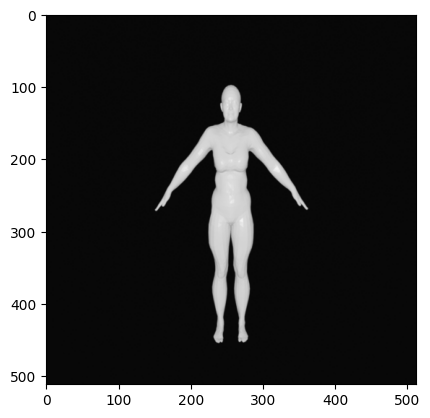

In [29]:
# Lendo uma imagem de amostra

test_image_path = config['destination_path'] + "/syn_f000012-3-Pos/front.png"#"/content/unzipped_files/syn_f000012-3-Pos/front.png"#"/content/unzipped_files/syn_m029272-3-Pre/left.png" #"/content/unzipped_files/syn_f000012-3-Pos/front.png"


image = Image.open(test_image_path).convert("RGB")
image = image.resize((512, 512), resample=Image.BILINEAR)
image = np.asarray(image).copy()
plt.imshow(image)


Text(0.5, 1.0, 'Máscara de silheta (U2Net)')

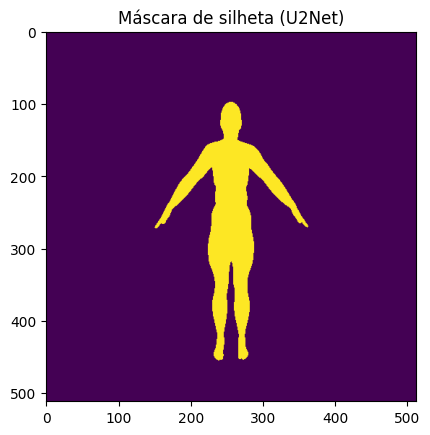

In [30]:
from dataset.dataset import U2NetToTensor

## Verificando saída da máscara da U2Net

u2netToTensor = U2NetToTensor()
mask = seg_module_u2net.extract_silhouette(u2netToTensor(image).unsqueeze(0).to(device))

plt.imshow(mask)
plt.title("Máscara de silheta (U2Net)")


Text(0.5, 1.0, 'Máscara de silheta (DeepLabV3)')

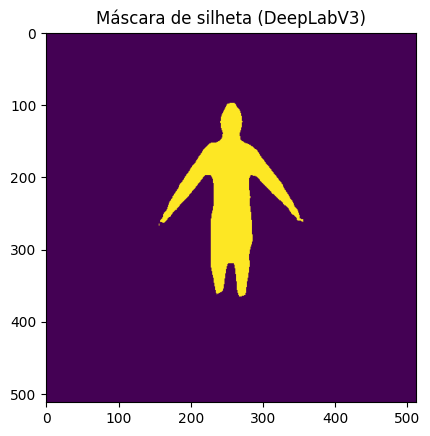

In [31]:
import torchvision.transforms as T

## Verificando saída da máscara da DeepLabV3


toTensor = T.ToTensor()
#inp = torch.tensor(image).permute((2,0,1)).unsqueeze(0).float().to(device)
inp  = toTensor(image).to(device).unsqueeze(0)
mask = seg_module_deep_lab.extract_silhouette(inp)
plt.imshow(mask)
plt.title("Máscara de silheta (DeepLabV3)")
#plt.savefig("silhueta.png")


Keypoints detectados: {'top_head': (257, 98), 'neck': (257, 124), 'shoulders': (257, 151), 'waist': (257, 232), 'hips': (257, 258), 'knees': (257, 312), 'ankles': (257, 366)}


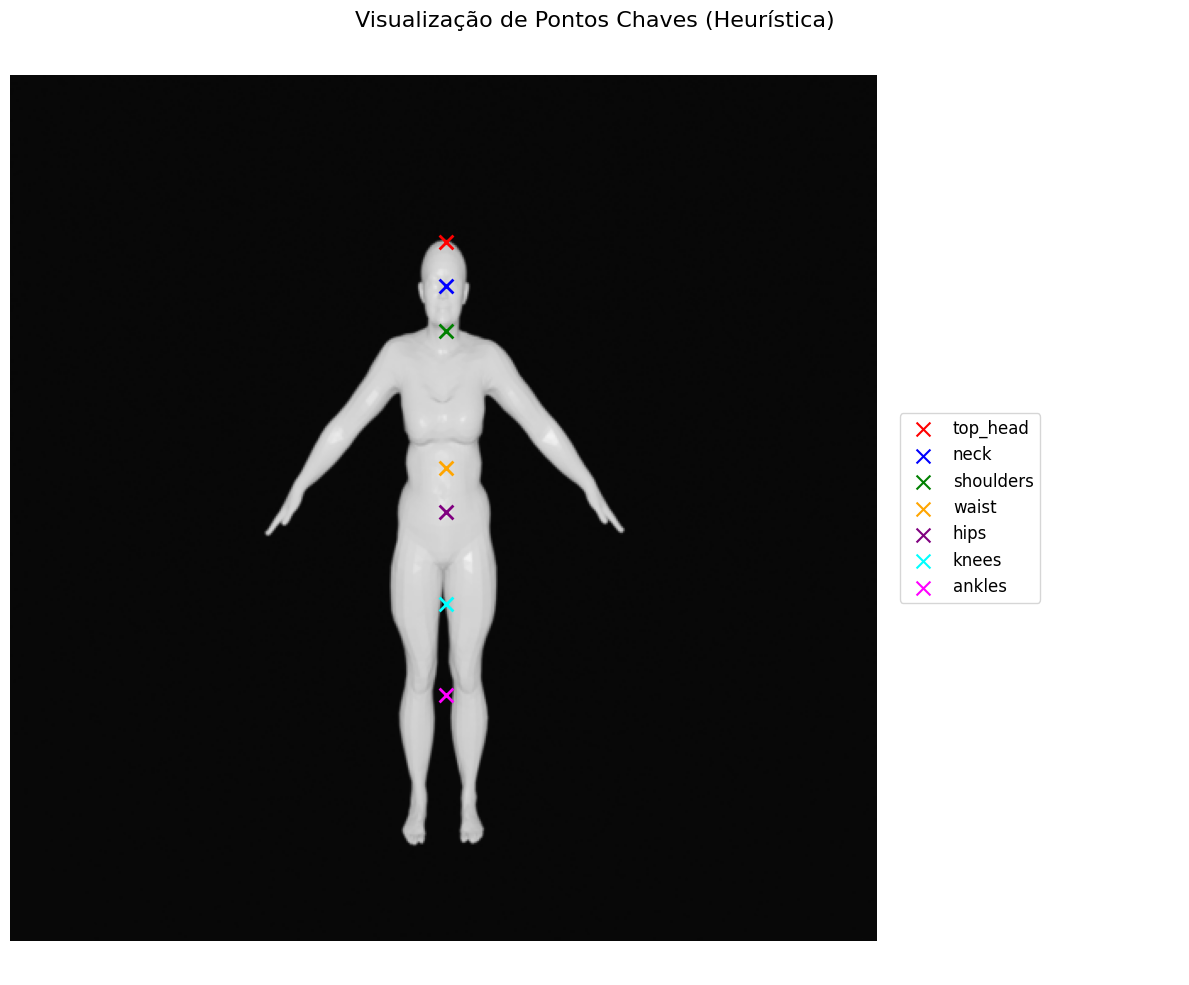

In [32]:
## Vericando pontos chaves da método baseline
keypoints = kp_module_heuristica.extract_keypoints(mask)
print("Keypoints detectados:", keypoints)

visualizar_keypoints(
    test_image_path,
    keypoints,
    "Visualização de Pontos Chaves (Heurística)",
    "keypoints_heuristica.png"
)

Keypoints detectados: {'top_of_head': (254, 98), 'neck': (256, 167), 'shoulder_left': (225, 167), 'shoulder_right': (288, 168), 'waist': (258, 268), 'hip_left': (243, 268), 'hip_right': (274, 269), 'knee_left': (243, 352), 'knee_right': (266, 354), 'ankle_left': (244, 430), 'ankle_right': (269, 429)}


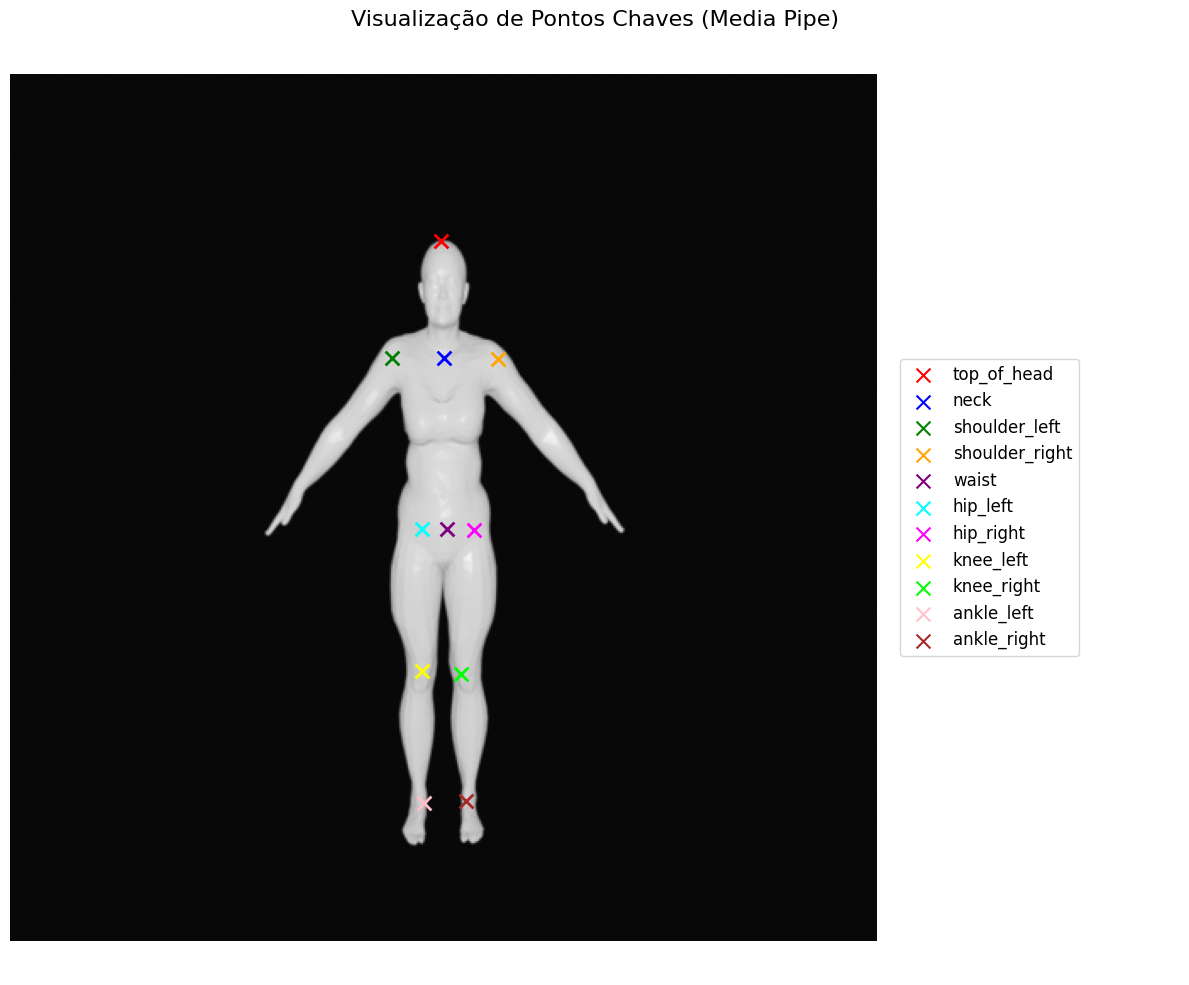

In [33]:
## Vericando pontos chaves da método BlazePose

keypoints = kp_module_mediapipe.extract_keypoints(image, mask)
print("Keypoints detectados:", keypoints)

visualizar_keypoints(
    test_image_path,
    keypoints,
    "Visualização de Pontos Chaves (Media Pipe)",
    "keypoints_mediapipe.png"
  )


Keypoints detectados: {'top_of_head': (254, 98), 'neck': (255, 166), 'shoulder_left': (281, 166), 'shoulder_right': (230, 166), 'waist': (254, 265), 'hip_left': (272, 265), 'hip_right': (237, 265), 'knee_left': (267, 351), 'knee_right': (238, 351), 'ankle_left': (272, 429), 'ankle_right': (238, 423)}


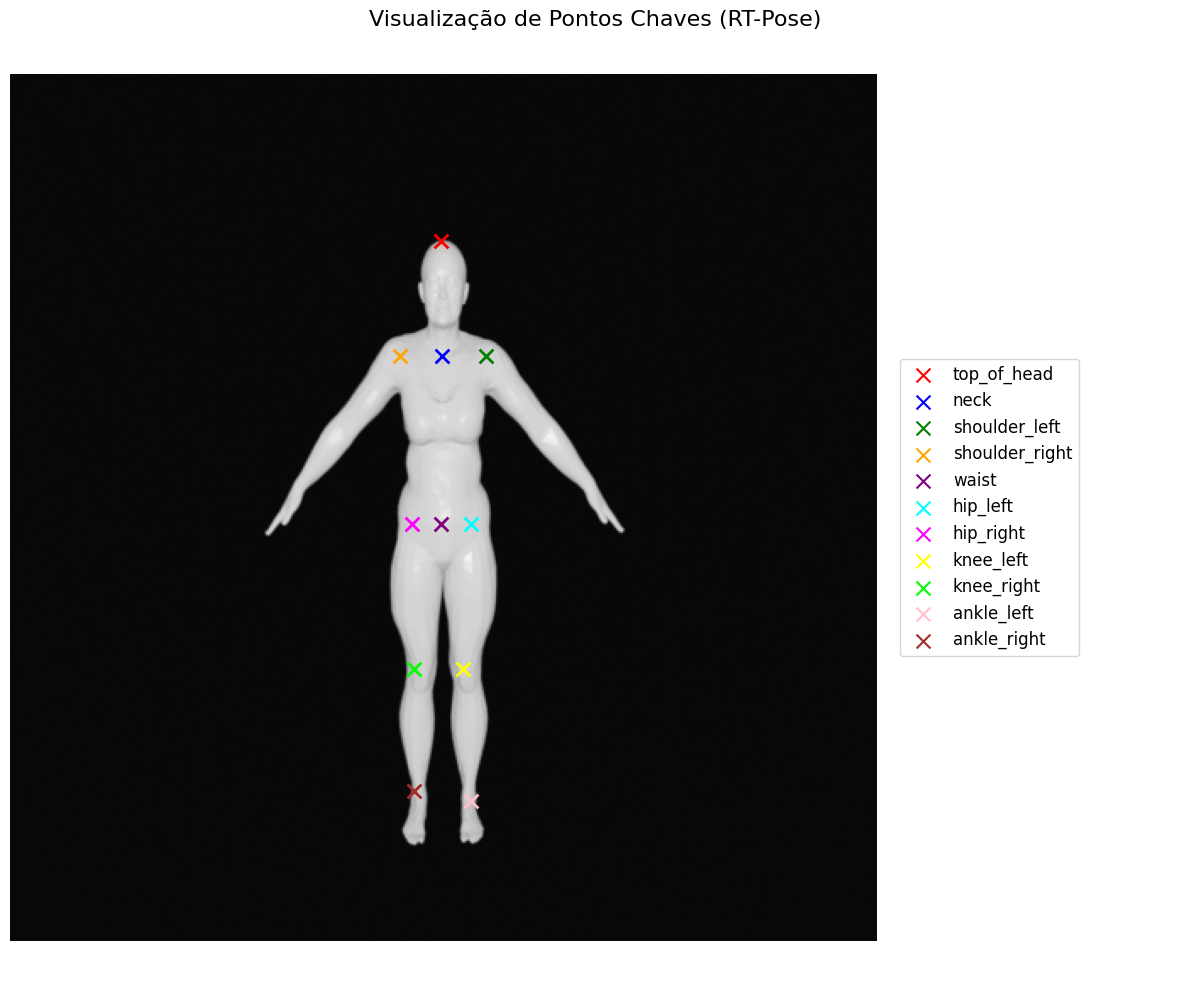

In [34]:
## Vericando pontos chaves da método RT-Pose

keypoints = kp_module_rtpose.extract_keypoints(image, mask)
print("Keypoints detectados:", keypoints)

visualizar_keypoints(
    test_image_path,
    keypoints,
    "Visualização de Pontos Chaves (RT-Pose)",
    "keypoints_mediapipe.png"
  )


In [35]:
import gc
del keypoints, kp_module_heuristica, kp_module_mediapipe, kp_module_rtpose, seg_module_deep_lab, seg_module_u2net
gc.collect()

6824

###  Treinamento do XGBoost

O XGBoost é um modelo de Aprendiza de Máquina conhecido por seu com desempenho em tarefas de classificação e regressão. É um modelo mais otimizado para treinamento em CPU. Vai servir com uma baseline para outro módulo regressor chamado DepthwiseSeparableConv1DRegressor que é mais suscetível para implantação mobile.

#### Preparação dos dados para treinar o XGBoost

In [36]:

# Criação do DataLoader
treino_loader = DataLoader(
    dataset=treino_dataset,
    batch_size=1,
    shuffle=False,
    #pin_memory=True,
    #num_workers=2
)


Considerando que devemos extrair informações de pontos chaves, então criamos o módulo ExtractFeaturesKeypoints reponsável por extrair
um vetor de características onde cada componente deste vetor corresponde à norma euclidiana (distância) entre N corrdenadas 2D de pontos chaves detectados da silhueta, porém devido a simetria da distância euclidiana e para evitar redundância de valores, usamos apenas pares de pontos únicos sem repetição.

$$
\|\mathbf{a} - \mathbf{b}\|_2 = \sqrt{(a_1 - b_1)^2 + (a_2 - b_2)^2 + \dots + (a_n - b_n)^2}
$$

A fórmula acima calcula distâncias euclidianas aplicando a norma L2 às diferenças vetoriais entre pontos chaves. Isso é alcançado usando `torch.norm(ponto2 - ponto1)`. Tem o mesmo efeito de computar a distância euclidiana entre dois pontos cartesianos.




A função `generate_regressor_data` a seguir vai gerar e salvar os tensores que armazenam as features extraídas do pontos chaves
e os vetores de medidas alvos que devemos estimar. Em suma, armazenamos dois tensores de vetores de caractéristicas extraídas dos pontos chaves com tamanho `BxN` onde B é o total de amostras e N é o total de distâncias computadas no módulo `ExtractFeaturesKeypoints`, enquanto outro tensor possui o tamanho `Bx9` para as nove medidas corporais que devemos regredir. Um modelo de Regressão Múltipla de Aprendizado de Máquina ou Aprendizado Profundo deve aprender uma função não linear que vai converter o vetor  `BxN` para o vetor `Bx9`.

In [37]:
@torch.no_grad()
def generate_regressor_data(treino_loader, seg_module, kp_module, feature_extractor, save_tensors=False):
  from tqdm import tqdm

  """
    Gera os dados de entrada e saída para o treinamento de um modelo de regressão (ex: MLP),
    a partir de imagens de treino, utilizando módulos de segmentação e detecção de pontos-chave.

    Args:
    ----------
    treino_loader : torch.utils.data.DataLoader
        DataLoader contendo as imagens e os rótulos para o treinamento.

    seg_module : objeto de segmentação
        Módulo responsável por extrair a silhueta da imagem (ex: DeepLabV3, U2Net).

    kp_module : objeto de detecção de pontos-chave
        Módulo que extrai os keypoints da silhueta (ex: MediaPipeKeypointsModule, RTPoseKeypointDetectorModule).
    feature_extractor:  objeto de extração de vetores de características dos pontos-chave
         Módulo que extrai vetores de características dos pontos chaves.
    save_tensors : bool, opcional (default=False)
        Se True, salva os tensores gerados (features e labels) em arquivos `.pt` no caminho especificado em `config['log_path']`.

    Resumo do funcionamento:

    - Para cada imagem no `treino_loader`, a função:
        1. Move a imagem e o rótulo para o dispositivo (CPU/GPU).
        2. Extrai a silhueta da imagem usando `seg_module`.
        3. Se a silhueta estiver vazia, gera um vetor de características zerado como fallback.
        4. Caso contrário, extrai os pontos-chave da silhueta usando `kp_module`.
        5. Converte os keypoints em um vetor de características com `feature_extractor`.
        6. Armazena os vetores de características e os rótulos em listas.

    - Ao final, empilha os vetores em tensores `X_treino_regressao` e `y_treino_regressao`.

    - Se `save_tensors=True`, salva os tensores como arquivos `.pt`.

    Returns:
    -------
    X_treino_regressao : torch.Tensor
        Tensor contendo os vetores de características extraídos de cada imagem.

    y_treino_regressao : torch.Tensor
        Tensor contendo os rótulos correspondentes às imagens.

    Observações:
    -----------
    - A função imprime o total de imagens em que os pontos-chave não foram detectados.
    - É necessário que `config` esteja definido globalmente com as chaves `log_path` e `regressor_module_name`.
    - A variável `total_keypoints_not_detected` precisa ser inicializada antes do loop.
  """
  global aux
  features_list = []
  labels_list = []
  total_keypoints_not_detected = 0
  total_masks_not_segmented = 0

  for img, label in tqdm(treino_loader, desc="Criando dados de treino da MLP"):
    img, label = img.to(device), label.to(device) # move a imagem e os rótulos para o dispositivo.

    mask = seg_module.extract_silhouette(img) # extrai a silhueta da imagem.

    # se a silhueta estiver vazia, usa medidas zeradas como fallback
    if mask.max() == 0:
        #  print("Máscara vazia")
          #features = torch.zeros(100).to(device)  # fallback
          total_masks_not_segmented = total_masks_not_segmented + 1
          continue # ignora
    else:
          if isinstance(kp_module, MediaPipeKeypointsModule) or isinstance(kp_module, RTPoseKeypointDetectorModule):

            if isinstance(seg_module, U2NetSegmentationModule):
                img_unormalized = unnormalize_tensor(img.squeeze().cpu().detach())
                img_unormalized = (img_unormalized * 255).clip(0, 255).astype(np.uint8) # converte para RGB
            elif isinstance(seg_module, DeepLabSegmentationModule):
                img_unormalized = (img * 255).clamp(0, 255).byte() # converte para RGB
                img_unormalized = img_unormalized.squeeze().permute((1,2,0)).cpu().detach()
                img_unormalized = img_unormalized.numpy().astype(np.uint8)

            # detectar pontos chaves
            keypoints = kp_module.detector.detect(
                 img_unormalized,
                 mask
            )

          else:
            keypoints = kp_module.extract_keypoints(mask)

          if keypoints is not None: # se não detectou pontos chaves
            features = feature_extractor(keypoints).to(device)
          else:
            total_keypoints_not_detected =  total_keypoints_not_detected + 1
            continue

    label = label.view(-1).to(device)

    features_list.append(features.cpu())
    labels_list.append(label.cpu())


  # Conversão para tensores e salva
  X_treino_regressao = torch.stack(features_list)  # shape: [total_amostras, total_distancias]
  y_treino_regressao = torch.stack(labels_list)    # shape: [total_amostras, total_medidas_alvo]

  if save_tensors:
    torch.save(X_treino_regressao,
               os.path.join(config['log_path'],
                            "X_treino_regressao_{}_{}.pt".format(config['segmentation_module_name'],config['keypoint_module_name'])
    ))
    torch.save(y_treino_regressao, os.path.join(
        config['log_path'],
        "y_treino_regressao_{}_{}.pt".format(config['segmentation_module_name'],config['keypoint_module_name'])
    ))

  print("[INFO] Total de imagens com Pontos Chaves não detectados: ", total_keypoints_not_detected)
  print("[INFO] Total de imagens com máscaras previstas vazias: ", total_masks_not_segmented)

  return X_treino_regressao, y_treino_regressao


In [ ]:
config

{'colab': True,
 'dataset_path': '/content/drive/MyDrive/Colab Notebooks/SelecaoINOVIA/datasets',
 'destination_path': '/content/unzipped_files',
 'log_path': '/content/deteccao_pontos_chaves/log',
 'regressor_module_name': 'XGBoost',
 'keypoint_module_name': 'RTPose',
 'segmentation_module_name': 'U2Net',
 'train': {'batch_size': 120,
  'learning_rate': '1e-7',
  'u2net_seg_human_model_path': ''}}

Nota: não esqueça de alterar o caminho para os pesos da U2Net no arquivo de configuração.
- O Link para baixar o modelo u2net_human_seg.pth é [U2Net](https://drive.google.com/file/d/1m_Kgs91b21gayc2XLW0ou8yugAIadWVP/view?usp=sharing)
- Se estiver no Colab, arraste o arquivo  u2net_human_seg.pth para o ambiente do
colab no canto esquerdo da tela.

In [38]:

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [39]:
## Instanciação dos módulo de Segmentação

if config['segmentation_module_name'] == 'DeepLabV3':
  seg_module = DeepLabSegmentationModule(device=device)
elif config['segmentation_module_name'] == 'U2Net':
  seg_module = U2NetSegmentationModule(
      config['train']['u2net_seg_human_model_path'],
      device
  )
else:
   raise ValueError(f"Módulo de segmentação desconhecido: {config['segmentation_module_name']}")


In [40]:
## Instanciação dos módulo de Detecção de Pontos Chaves


if config['keypoint_module_name'] == 'RTPose':
  kp_module = RTPoseKeypointDetectorModule()
elif config['keypoint_module_name'] == 'BlazePose':
  kp_module = MediaPipeKeypointsModule()
elif config['keypoint_module_name'] == 'Heuristic':
  kp_module = KeypointsModule()
else:
   raise ValueError(f"Módulo de detecção de pontos chaves desconhecido: {config['keypoint_module_name']}")


## Instanciação do extrator de caractéristicas de pontos chaves

feature_extractor = ExtractFeaturesKeypoints().to(device)


2025-09-27 23:49:23.560 | INFO     | rt_pose.pipeline:_load_detector:70 - Loading detector from `PekingU/rtdetr_r50vd_coco_o365`...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-27 23:49:25.110 | INFO     | rt_pose.pipeline:_load_detector:74 - Detector loaded to `cuda` with dtype `torch.float32`!
2025-09-27 23:49:25.110 | INFO     | rt_pose.pipeline:_load_pose_estimator:79 - Loading pose estimator from `usyd-community/vitpose-plus-small`...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-27 23:49:26.359 | INFO     | rt_pose.pipeline:_load_pose_estimator:83 - Pose estimator loaded to `cuda` with dtype `torch.float32`!
2025-09-27 23:49:26.360 | INFO     | rt_pose.pipeline:__init__:66 - Pipeline initialized successfully!


Para cada amostra de treino, extrairemos os vetores de características correspondentes aos pontos-chave, juntamente com seus respectivos rótulos. Esses dados serão então organizados e salvos em tensores do PyTorch, permitindo reutilização eficiente durante a execução do notebook.

- Os tensores serão salvo no config['log_path']

In [41]:
config['log_path']  =  os.path.join(codigo_base_path, "log")

In [42]:
import time

start_time = time.time()


X_treino_regressao, y_treino_regressao = generate_regressor_data(
    treino_loader = treino_loader,
    seg_module = seg_module,
    kp_module = kp_module,
    feature_extractor = feature_extractor,
    save_tensors = True)

end_time = time.time()

elapsed_time = end_time - start_time

print(f"Tempo de execução: {elapsed_time:.2f} segundos")


Criando dados de treino da MLP:   0%|          | 47/15392 [00:06<34:05,  7.50it/s]


KeyboardInterrupt: 

In [ ]:
X_treino_regressao_numpy = X_treino_regressao.cpu().detach().numpy()
y_treino_regressao_numpy =  y_treino_regressao.cpu().detach().numpy()

Antes de iniciar o treinamento do XGBoost, vamos preparar os vetores de caracteríticas de entrada usando uma normalização similar aquela normalização usada nas medidas alvos no `RegressaoDataset`. Nesse, vamos apenas dividir cada vetor de características (distancias euclidianas computadas) extraídos dos pontos chave por seu valor máximo. Isso pode ser útil pois podemos colocar os valores na mesma escala, o que certamente facilita o aprendizado do modelo e evita que "features" com valores maiores dominem sobre outras. Logo, essa normalização simples, baseada no valor máximo de cada vetor, deve garantir que todas as distâncias fiquem em uma faixa comparável, geralmente entre 0 e 1. Além disso, essa normalização deve preservar as proporções relativas entre os pontos.

In [ ]:
maximo_linha = np.max(X_treino_regressao_numpy, axis=1, keepdims=True) # computa o maior valor de cada vetor no conjunto de treino de entrada
print(maximo_linha)

[[398.]
 [395.]
 [404.]
 ...
 [414.]
 [372.]
 [369.]]


In [ ]:
X_treino_regressao_numpy = X_treino_regressao_numpy / maximo_linha + 1e-10 # normalizando entrada

In [ ]:

# Criando uma instância do XGBRegressor
base_model = XGBRegressor(n_estimators=100, learning_rate=0.1, device='gpu', random_state=2025)

# Wrap o XGBoost com MultiOutputRegressor
model = MultiOutputRegressor(base_model)
start = time.time()
# Treinando o modelo
model.fit(X_treino_regressao_numpy, y_treino_regressao_numpy)
print("XGBoost tempo de treinamento:", time.time() - start)

# Salvando o modelo treinado
joblib.dump(model, os.path.join(config['log_path'],"{}_{}_multioutput_xgb_model.pkl".format(
                   config['segmentation_module_name'],
                   config['keypoint_module_name']
                )))


XGBoost tempo de treinamento: 1.258223533630371


['/content/deteccao_pontos_chaves/log/U2Net_Heuristic_multioutput_xgb_model.pkl']

### Treinamento do Regressor baseado em DepthwiseSeparableConvolutioin 1D

In [ ]:
# Um simple Dataset Pytorch para carregar os tensores em batchs
class SimpleDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


In [ ]:
batch_size = config['train']['batch_size']  # ou outro conforme a capacidade da GPU
regressor_treino_dataset = SimpleDataset(X_treino_regressao, y_treino_regressao)
regressor_treino_loader = DataLoader(regressor_treino_dataset, batch_size=batch_size, shuffle=True)


O módulo de regressão `DepthwiseSeparableConv1DRegressor` visa reduzir o número de parâmetros e operações — ideal para implantação em dispositivos móveis. Quando `groups=in_channels` faz com que o Conv1d opere independentemente em cada canal (em profundidade). Por outro lado, quando
vkernel_size=1` usando apenas uma projeção não linear que agrega canais (em pontos no feature map). Usamos apenas Conv1D pois estamos transformação um sinal 1D (vetor de características) para outro sinal 1D (vetor de medidas corporais).


O conceito de Depthwise Separable Convolutioin é usado é arquitetura famosdas como MobileNet e MobileVit.



In [ ]:

# Configurações e instanticação do modelo

if isinstance(kp_module, MediaPipeKeypointsModule) or  isinstance(kp_module, RTPoseKeypointDetectorModule):
  model = DepthwiseSeparableConv1DRegressor(input_length=55).to(device)

else:
  model = DepthwiseSeparableConv1DRegressor(input_length=21).to(device)



criterion = torch.nn.MSELoss()  # ou nn.CrossEntropyLoss() se for classificação
optimizer = torch.optim.Adam(model.parameters(), lr=float(config['train']['learning_rate']))
print(model)

DepthwiseSeparableConv1DRegressor(
  (depthwise): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (pointwise): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
  (relu): ReLU()
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,), groups=16)
    (1): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (2): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=672, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=9, bias=True)
  )
)


In [ ]:
## Treinando o DepthwiseSeparableConv1DRegressor
import time

start = time.time()
# Número de épocas
num_epochs = 2000
history = {"train_loss":[]}

for epoch in tqdm(range(num_epochs), desc="Treinando. Epochs: "):
    model.train()
    epoch_loss = 0.0

    for batch in regressor_treino_loader:
        features, labels = batch  # features: [B, N], labels: [B, 9]

        # Redimensionando de acordo com o tipo do kp_module
        if isinstance(kp_module, MediaPipeKeypointsModule) or  isinstance(kp_module, RTPoseKeypointDetectorModule):
          features = features.view(features.size(0), 1, 55).to(device)
        else:
          features = features.view(features.size(0), 1, 21).to(device)
        labels = labels.view(labels.size(0), -1).to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(treino_loader)
    history['train_loss'].append(avg_loss)

end = time.time()

elapsed = end - start
hours, rem = divmod(elapsed, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Tempo de execução de treinamento: {int(hours)}h {int(minutes)}min {int(seconds)}s")


Treinando. Epochs: 100%|██████████| 2000/2000 [12:55<00:00,  2.58it/s]

Tempo de execução de treinamento: 0h 12min 55s


In [ ]:
# salvando parâmetros do modelo
torch.save(model.state_dict(),
           os.path.join(
               config['log_path'],
               "{}_{}_separable_conv_regressor_weights.pt".format(
                   config['segmentation_module_name'],
                   config['keypoint_module_name']
                )
  )
)

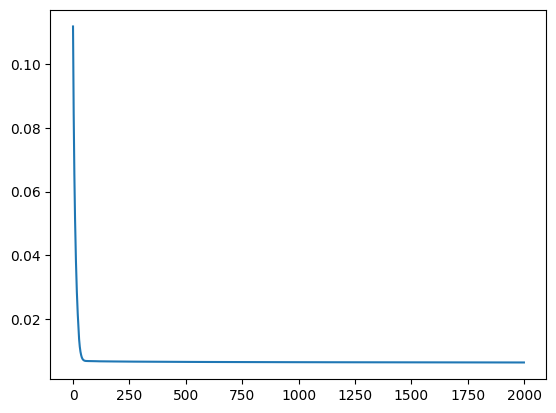

In [ ]:
plt.plot(history['train_loss'])

In [ ]:
# (OPCIONAL) descomente esse código no Google Colab para compactar e baixar o arquivo de ./log
# if USE_COLAB:
#   import shutil
#   from google.colab import files


#   shutil.make_archive("/content/log", "zip", "/content/deteccao_pontos_chaves/log")
#   files.download("log.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Próximos passos

Podemos prosseguir para a avaliação do fluxo de execução que deve carregar em algum momento os regressores salvos na pasta de log desse notebook.